# Project Instruction
* The Film Junky Union, a new community for classic film enthusiasts, is developing a system to filter and categorize film reviews. The aim is to train a model to automatically detect negative reviews. You will use a dataset of movie reviews from IMDB with polarity labeling to create a model to classify reviews as positive and negative. It needs to have an F1 value of at least 0.85.

## Initialization

**I did not use BERT 
* In the part of my reviews I put together the models based on past normalization

In [1]:
import math
import re
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, f1_score
from tqdm.auto import tqdm
from sklearn.linear_model import LogisticRegression
import nltk
from nltk.corpus import stopwords as nltk_stopwords
nltk.download('stopwords')
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# a próxima linha fornece gráficos de melhor qualidade em telas HiDPI
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# isso é para usar progress_apply, leia mais em https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Load Data

In [4]:
df_reviews = pd.read_csv('/datasets/imdb_reviews.tsv', sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
0,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,The pakage implies that Warren Beatty and Gold...,1,neg,0,train,8335
1,tt0068152,movie,$,$,1971,\N,121,0,"Comedy,Crime,Drama",6.3,2218,How the hell did they get this made?! Presenti...,1,neg,0,train,8336
2,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,There is no real story the film seems more lik...,3,neg,0,test,2489
3,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,Um .... a serious film about troubled teens in...,7,pos,1,test,9280
4,tt0313150,short,'15','15',2002,\N,25,0,"Comedy,Drama,Short",6.3,184,I'm totally agree with GarryJohal from Singapo...,9,pos,1,test,9281
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47326,tt0068398,tvEpisode,Étude in Black,Étude in Black,1972,\N,97,0,"Crime,Drama,Mystery",7.7,2254,This is another of my favorite Columbos. It sp...,10,pos,1,test,6038
47327,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Talk about being boring! I got this expecting ...,4,neg,0,test,989
47328,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,"I never thought I'd say this about a biopic, b...",8,pos,1,test,4163
47329,tt0223503,tvMovie,Îhatôbu gensô: KENjI no haru,Îhatôbu gensô: KENjI no haru,1996,\N,55,0,"Animation,Biography,Drama",7.3,278,Spirit and Chaos is an artistic biopic of Miya...,9,pos,1,test,4164


In [6]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

* Average rating and votes have missing values

In [7]:
df_reviews[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [8]:
df_reviews[df_reviews['votes'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [9]:
df_reviews[df_reviews['original_title']=='Mila Ass Painting']

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


* Since the rating exists in these cases of missing values, I'm going to replace the average rating with the average rating of the other films that received 9 and 10 in rating.

In [10]:
df_reviews['rating'].value_counts()

1     9589
10    9104
8     5576
4     5078
3     4709
7     4593
9     4343
2     4339
Name: rating, dtype: int64

In [11]:
df_reviews['average_rating'] = df_reviews['average_rating'].fillna(df_reviews['average_rating'][df_reviews['rating']>=9].mean())

* And the votes column I'll replace with the median.

In [12]:
df_reviews['votes'] = df_reviews['votes'].fillna(df_reviews['votes'].median())

In [13]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47331 non-null  float64
 10  votes            47331 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

## AED

Let's take a look at the number of films and reviews over the years.

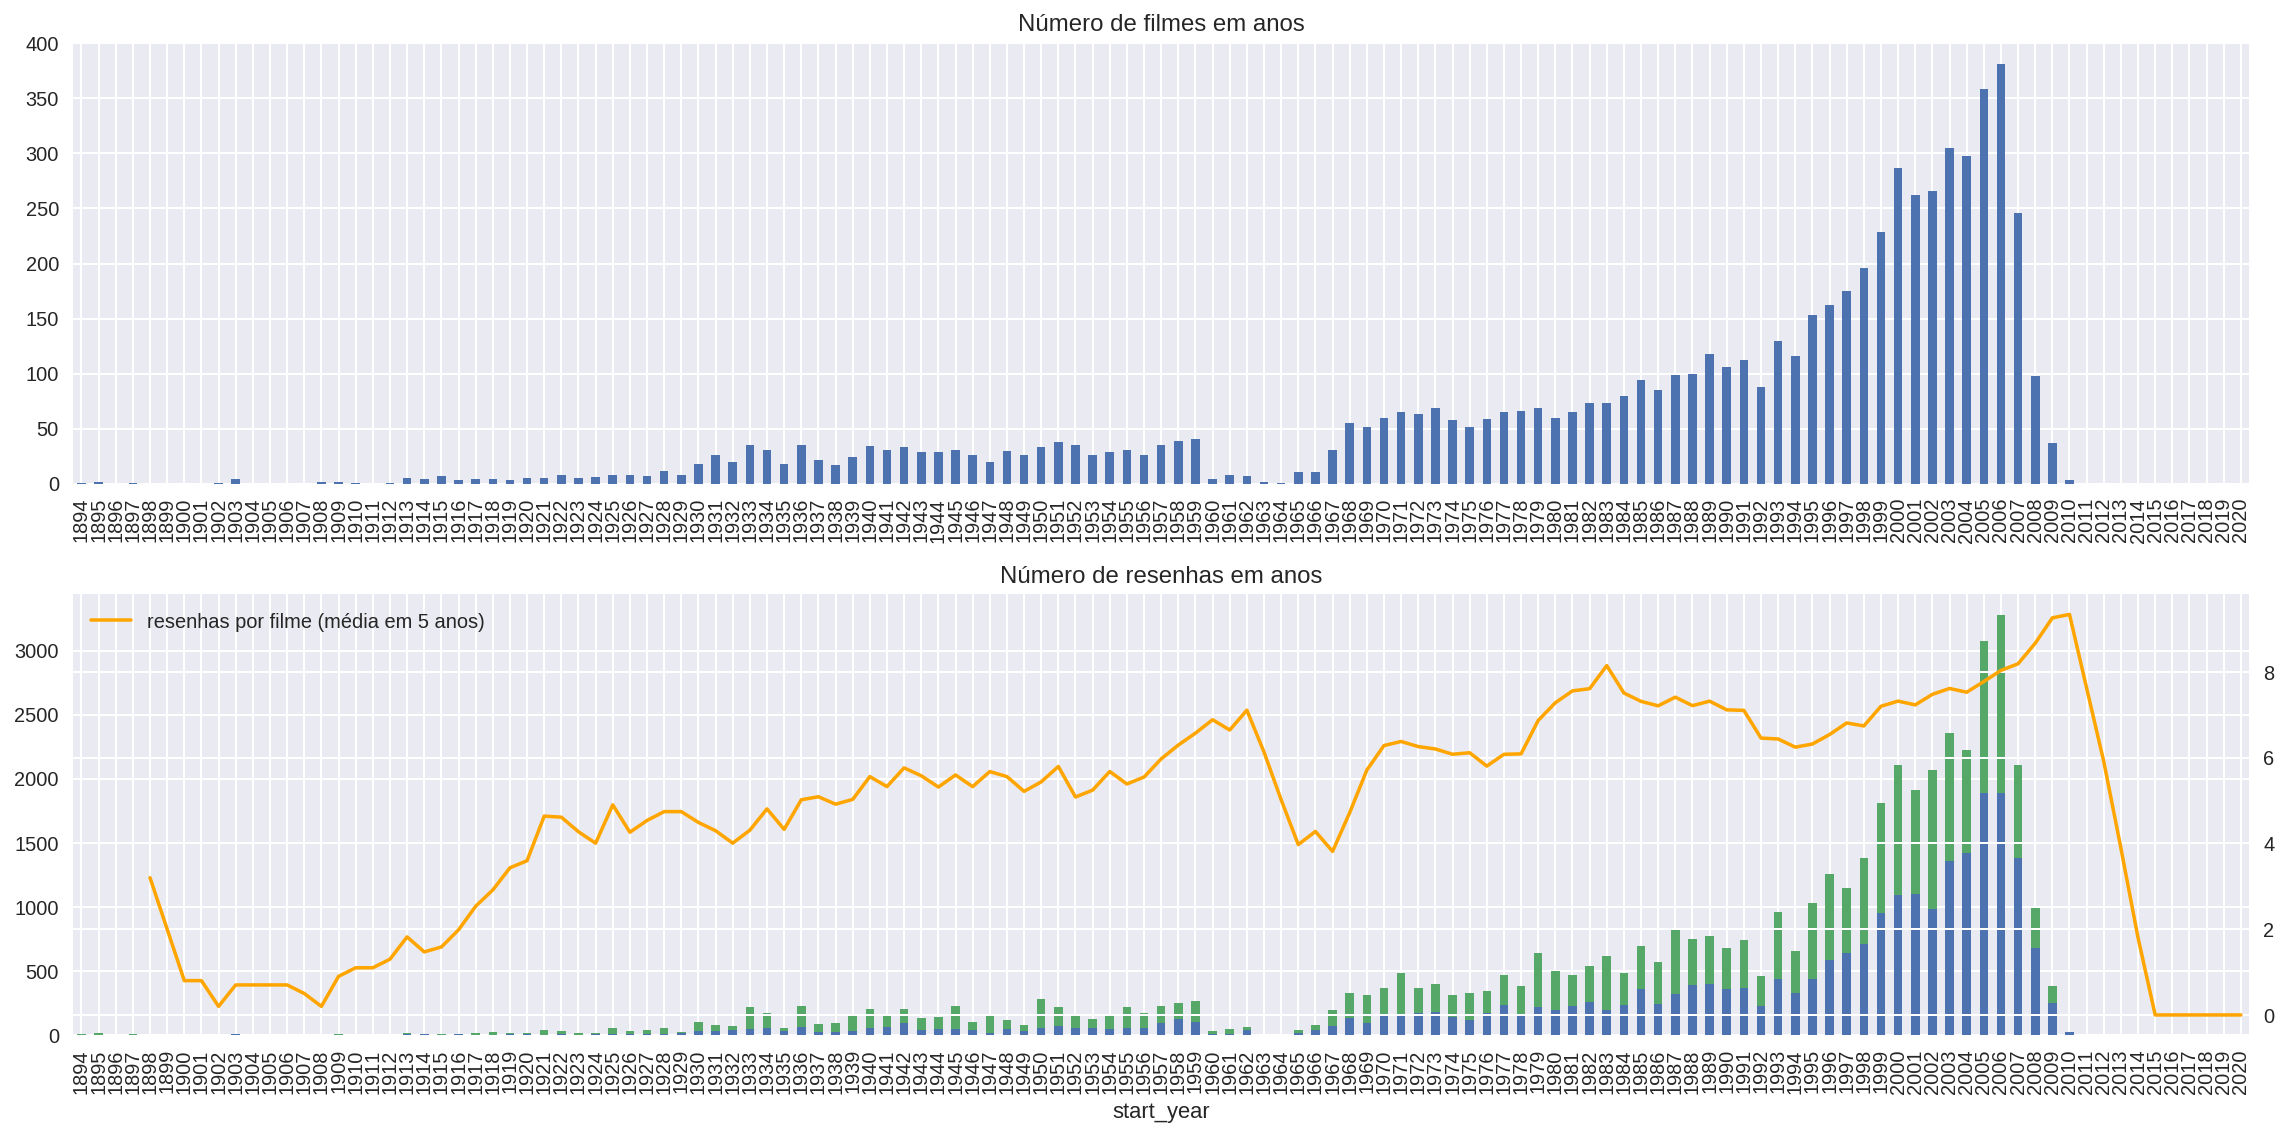

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Número de filmes em anos')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#reviews (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='resenhas por filme (média em 5 anos)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Número de resenhas em anos')

fig.tight_layout()

* The more films, the more reviews, which is to be expected. However, the average did not increase proportionally, indicating that there were only more reviews because more films were released, but most likely the number of reviews per film decreased over time.

Let's check the distribution of the number of reviews per movie with the exact count and the EDK (Estimated Density Kernel - just to see how it can differ from the exact count).

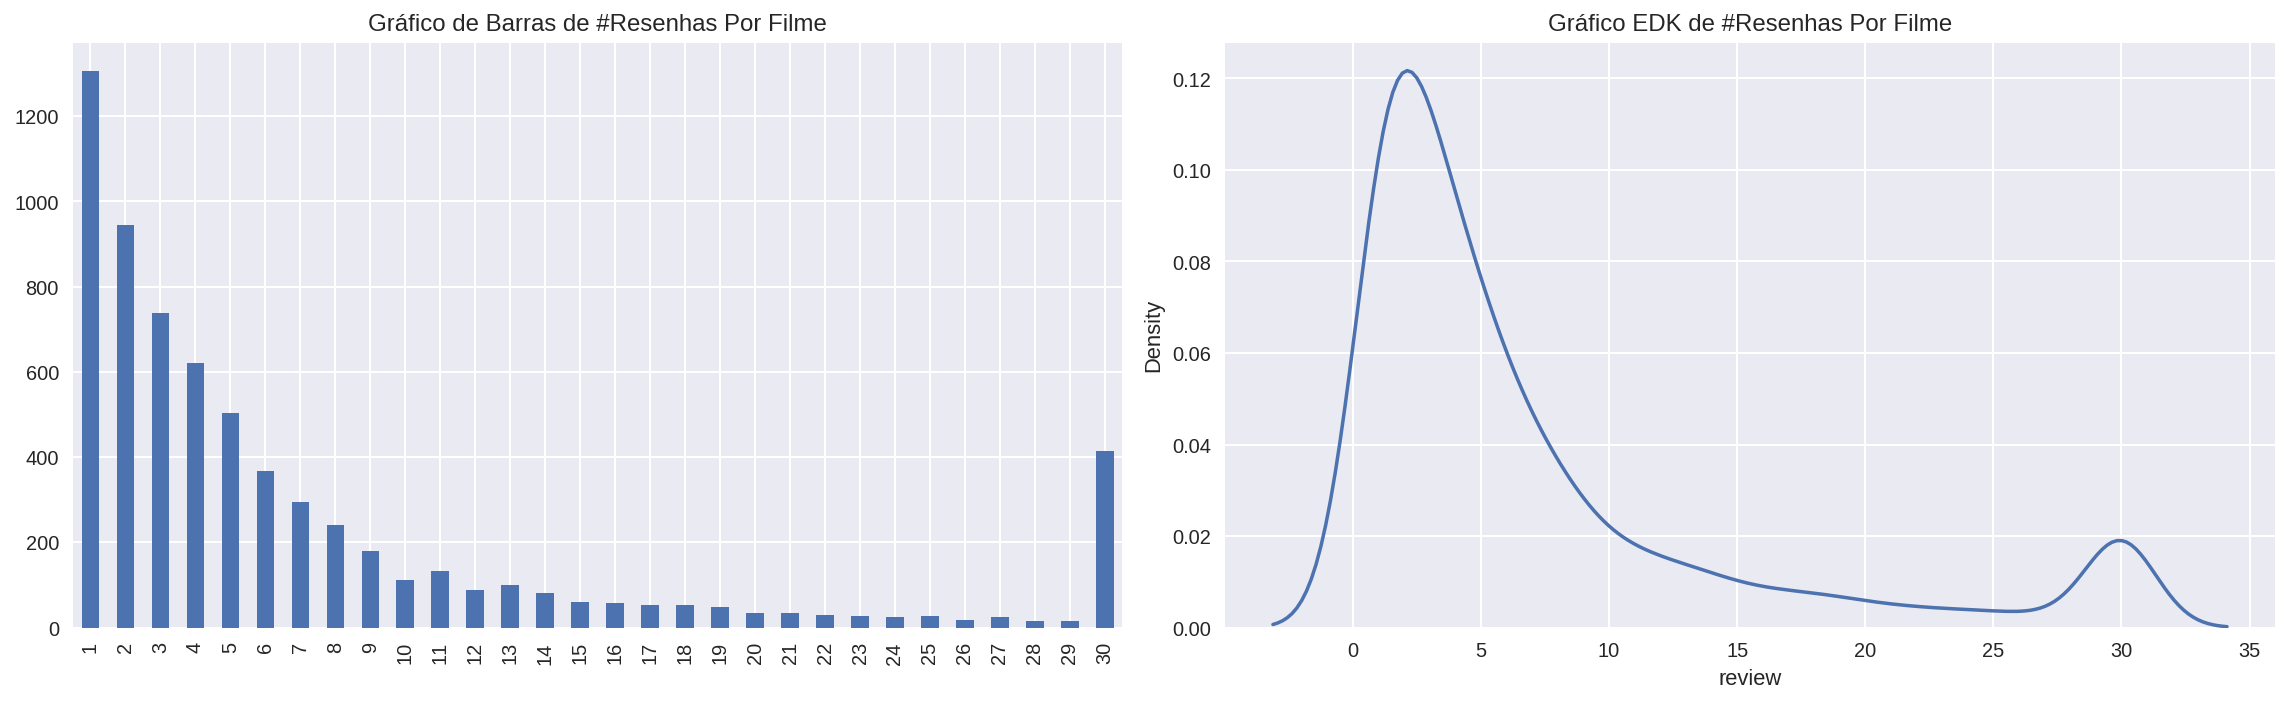

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Gráfico de Barras de #Resenhas Por Filme')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Gráfico EDK de #Resenhas Por Filme')

fig.tight_layout()

* What is confirmed here is that the number of reviews per movie falls over time.

In [16]:
df_reviews['pos'].value_counts()

0    23715
1    23616
Name: pos, dtype: int64

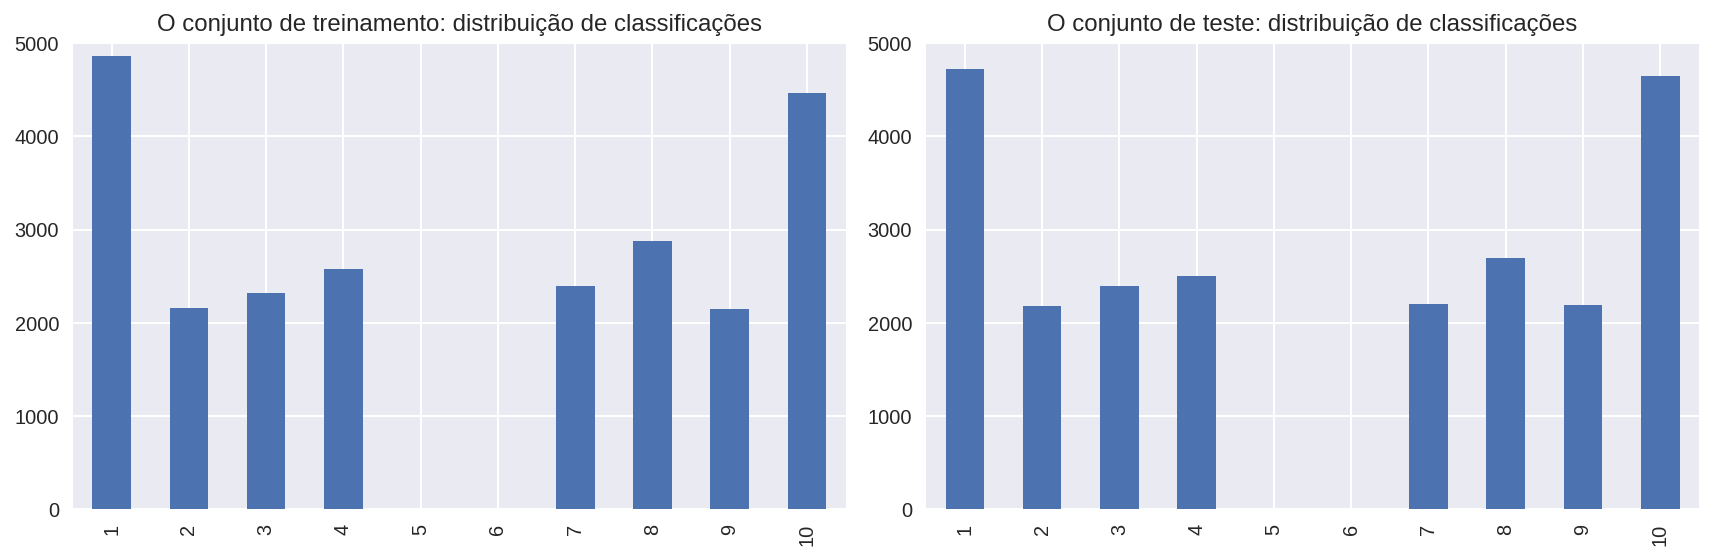

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de treinamento: distribuição de classificações')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('O conjunto de teste: distribuição de classificações')

fig.tight_layout()

* Everything distributed correctly

Distribution of negative and positive reviews over the years for two parts of the data set

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:1666: UserWarning: Support for alternate kernels has been removed. Using Gaussian kernel.
  warnings.warn(msg, UserWarning)


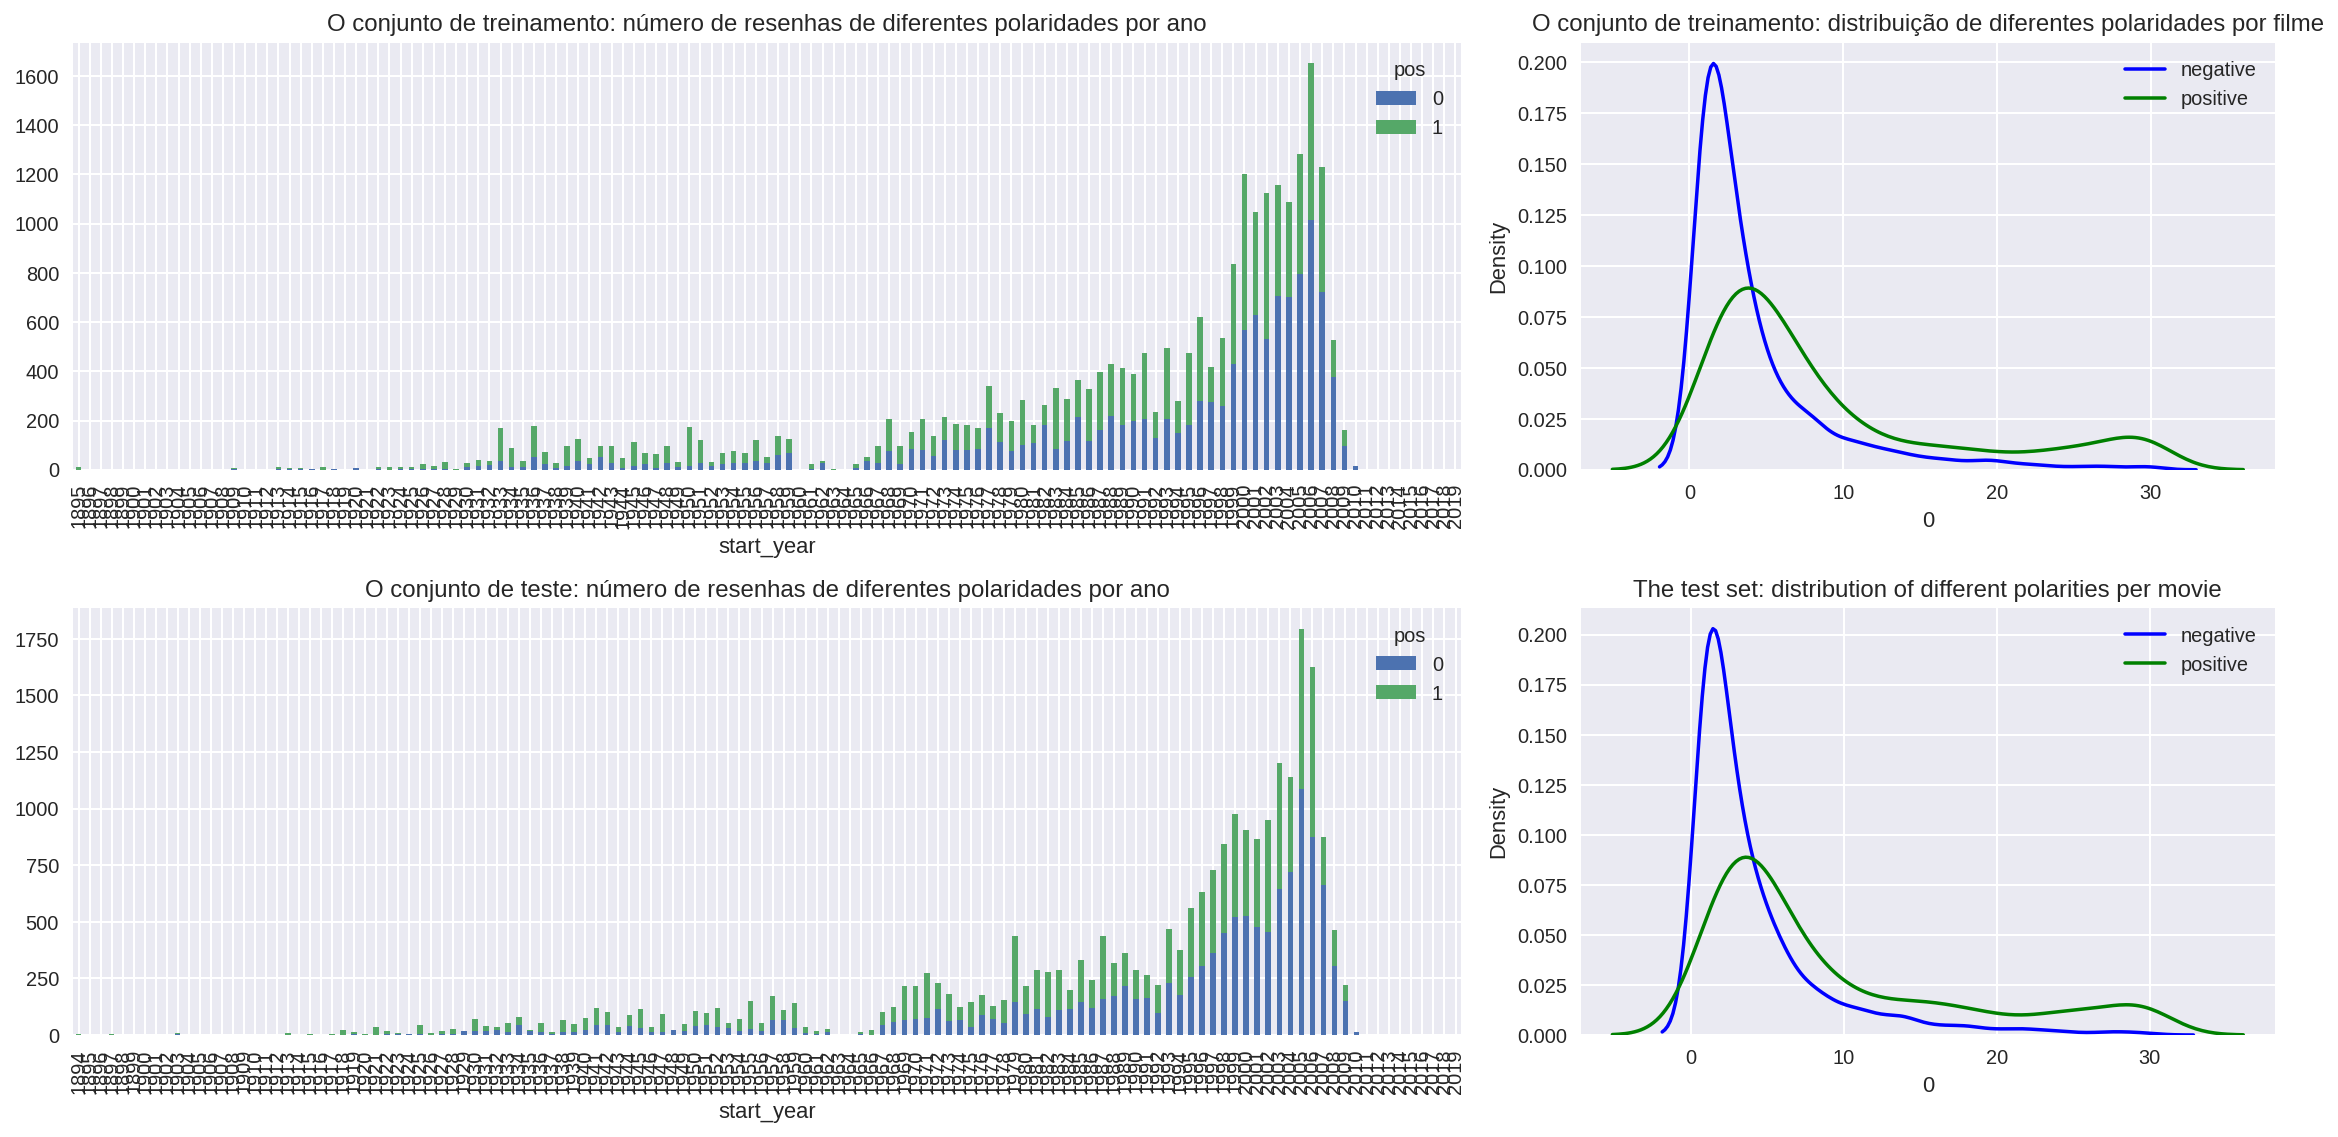

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de treinamento: número de resenhas de diferentes polaridades por ano')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('O conjunto de treinamento: distribuição de diferentes polaridades por filme')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('O conjunto de teste: número de resenhas de diferentes polaridades por ano')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('The test set: distribution of different polarities per movie')

fig.tight_layout()

* Everything distributed correctly, the test set appears to have more positive reviews.


## Evaluation procedure

Composing an evaluation routine that can be used for all the models in this project

In [19]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # Curva de precisão-revocação
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Valor F1
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Valor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # setting crosses for some thresholds
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Curva ROC')
        
        # Curva de precisão-revocação
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # definindo cruzamentos para alguns limiares
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Accuracy'] = metrics.accuracy_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Acurácia', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalization

We assume that all the templates below accept texts in lowercase and without digits, punctuation marks, etc.

In [20]:
pattern = r"[^a-zA-Z']"
df_reviews['review_norm'] = df_reviews['review'].apply(lambda x: re.sub(pattern, " ", x))

In [21]:
df_reviews['review_norm']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made   Presenti...
2        There is no real story the film seems more lik...
3        Um      a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos  It sp...
47327    Talk about being boring  I got this expecting ...
47328    I never thought I'd say this about a biopic  b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief  This was a joy to watch ...
Name: review_norm, Length: 47331, dtype: object

In [22]:
df_reviews['review']

0        The pakage implies that Warren Beatty and Gold...
1        How the hell did they get this made?! Presenti...
2        There is no real story the film seems more lik...
3        Um .... a serious film about troubled teens in...
4        I'm totally agree with GarryJohal from Singapo...
                               ...                        
47326    This is another of my favorite Columbos. It sp...
47327    Talk about being boring! I got this expecting ...
47328    I never thought I'd say this about a biopic, b...
47329    Spirit and Chaos is an artistic biopic of Miya...
47330    I'll make this brief. This was a joy to watch....
Name: review, Length: 47331, dtype: object

## Training / Testing Set

Fortunately, the entire data set is already divided into training/testing parts. The corresponding option is 'ds_part'.

In [23]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23535, 18)


## Pré models

In [24]:
X_train = df_reviews_train['review_norm']
X_test = df_reviews_test['review_norm']
y_train=df_reviews_train['pos']
y_test=df_reviews_test['pos']

In [25]:
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

### Model 0 - Constant

In [26]:
from sklearn.dummy import DummyClassifier

In [27]:
dummy_classifier = DummyClassifier(strategy="most_frequent")

# Fit the DummyClassifier on the training data
dummy_classifier.fit(X_train_tfidf, y_train)

# Make predictions using the DummyClassifier
y_pred = dummy_classifier.predict(X_test_tfidf)

# Calculate the accuracy of the DummyClassifier
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of DummyClassifier: {accuracy}")
f1 = f1_score(y_test, y_pred)
print("Valor F1:", f1)

Accuracy of DummyClassifier: 0.5015083917569577
Valor F1: 0.0


### Model 1 - NLTK, TF-IDF and Linear Regression

TF-IDF

In [28]:
model_1 = LogisticRegression()
model_1.fit(X_train_tfidf, y_train)

LogisticRegression()

In [29]:
y_val_pred = model_1.predict(X_test_tfidf)
accuracy = accuracy_score(y_test, y_val_pred)
print(f'Acurácia: {accuracy:.2f}')

Acurácia: 0.88


In [30]:
f1 = f1_score(y_test, y_val_pred)
print("Valor F1:", f1)

Valor F1: 0.8814761030196898


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.95
ROC AUC    0.98  0.95


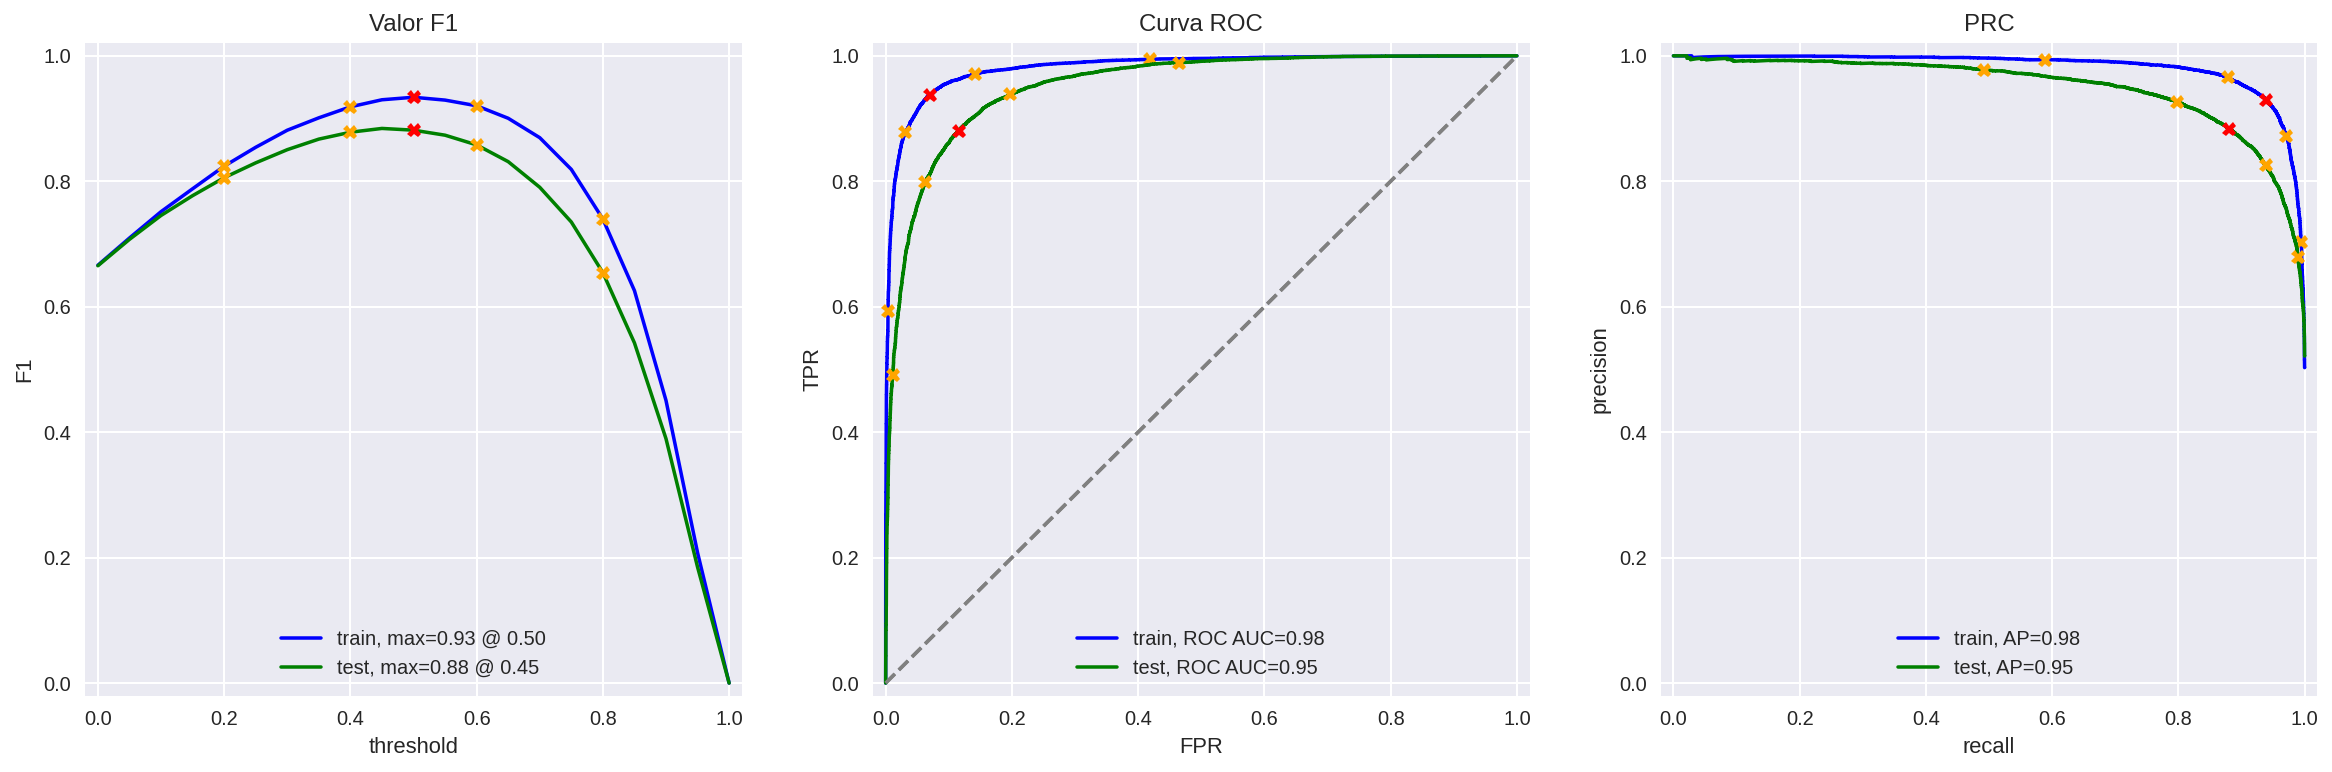

In [31]:
evaluate_model(model_1, X_train_tfidf, y_train, X_test_tfidf, y_test)

### Model 3 - spaCy, TF-IDF and Linear Regression

In [32]:
import spacy

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [33]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    #tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [34]:
df_reviews_test["texto_preprocessado"] = df_reviews_test["review"].apply(text_preprocessing_3)
df_reviews_train["texto_preprocessado"] = df_reviews_train["review"].apply(text_preprocessing_3)

In [35]:
X_train1 = df_reviews_train['texto_preprocessado']
X_test1 = df_reviews_test['texto_preprocessado']
y_train1=df_reviews_train['pos']
y_test1=df_reviews_test['pos']

In [36]:
tfidf_vectorizer1 = TfidfVectorizer()
X_train_tfidf1 = tfidf_vectorizer1.fit_transform(X_train1)
X_test_tfidf1 = tfidf_vectorizer1.transform(X_test1)

In [37]:
model_2 = LogisticRegression()
model_2.fit(X_train_tfidf1, y_train1)

LogisticRegression()

In [38]:
y_val_pred1 = model_2.predict(X_test_tfidf1)
accuracy1 = accuracy_score(y_test1, y_val_pred1)
print(f'Acurácia: {accuracy1:.2f}')

Acurácia: 0.88


In [39]:
f1 = f1_score(y_test1, y_val_pred1)
print("Valor F1:", f1)

Valor F1: 0.8750531960166824


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.94
ROC AUC    0.98  0.95


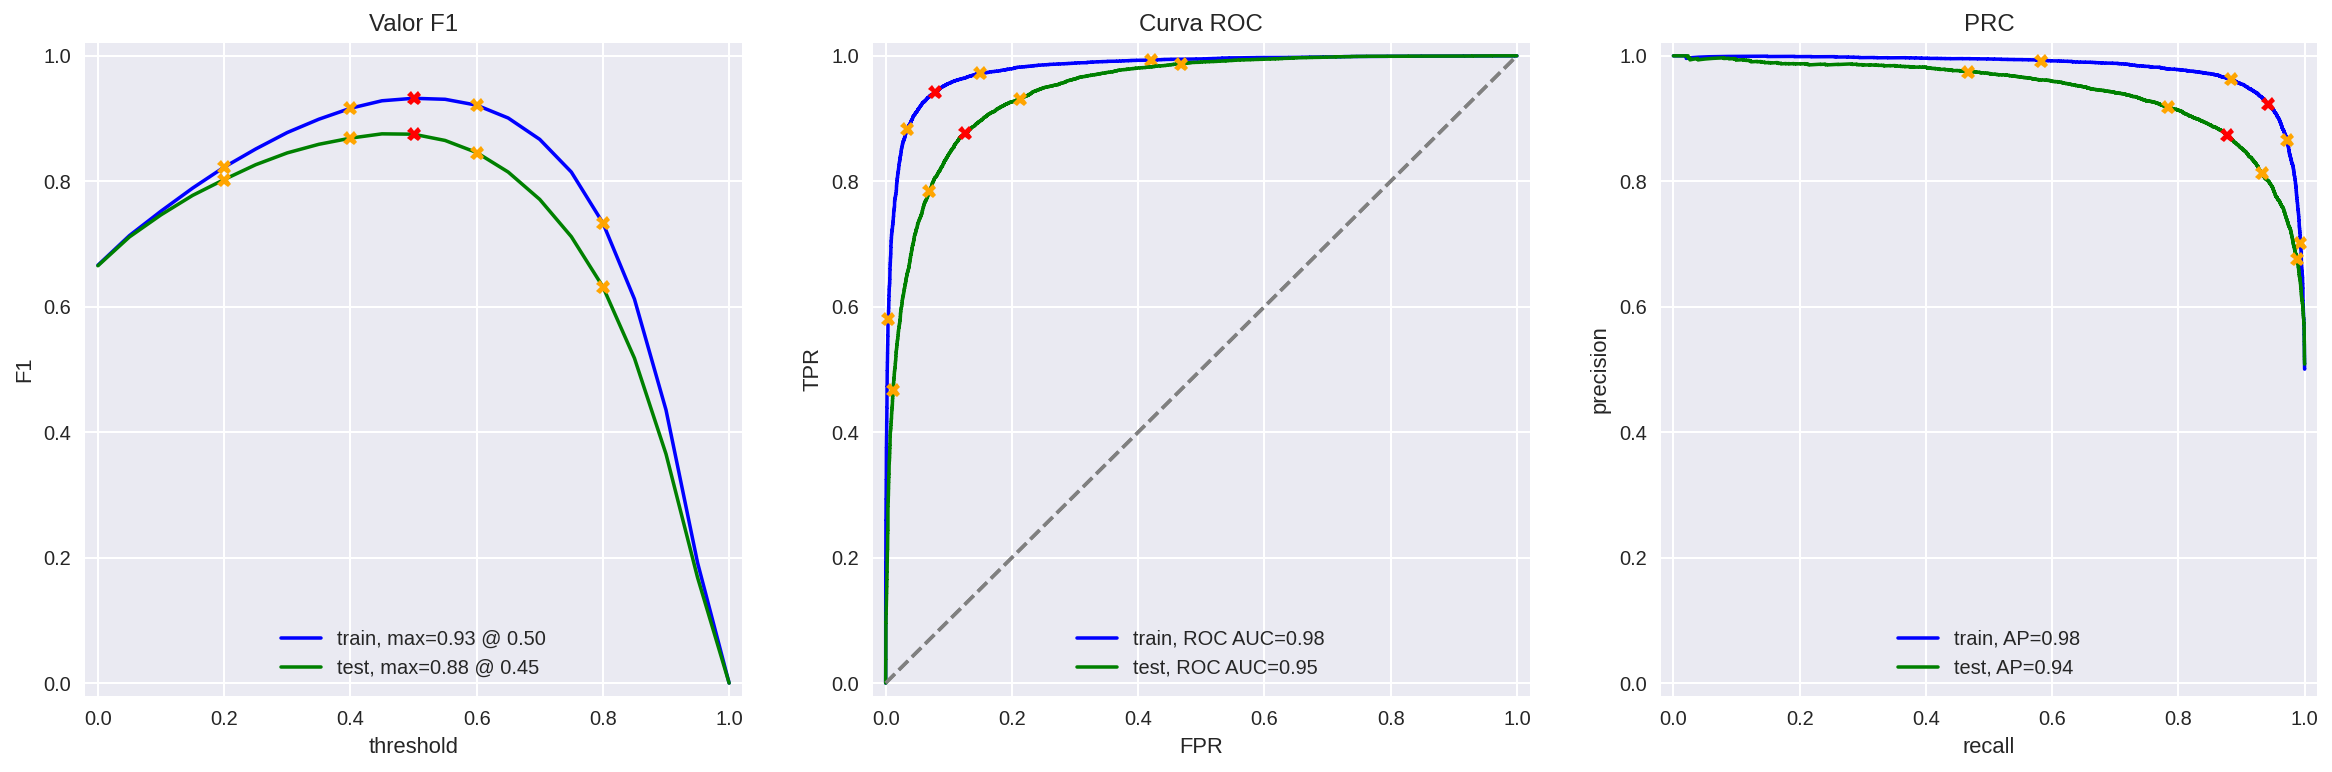

In [40]:
evaluate_model(model_2, X_train_tfidf1, y_train1, X_test_tfidf1, y_test1)

### Model 4 - SpaCy, TF-IDF and LGBMClassifier

In [41]:
lgbm_classifier = LGBMClassifier()
lgbm_classifier.fit(X_train_tfidf, y_train)

LGBMClassifier()

In [42]:
y_predx = lgbm_classifier.predict(X_test_tfidf)


accuracy = accuracy_score(y_test, y_predx)

In [43]:
print(f"Acurácia do modelo: {accuracy}")

Acurácia do modelo: 0.8593159124707882


In [44]:
f1 = f1_score(y_test, y_predx)
print("Valor F1:", f1)

Valor F1: 0.860324825986079


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.98  0.94
ROC AUC    0.98  0.94


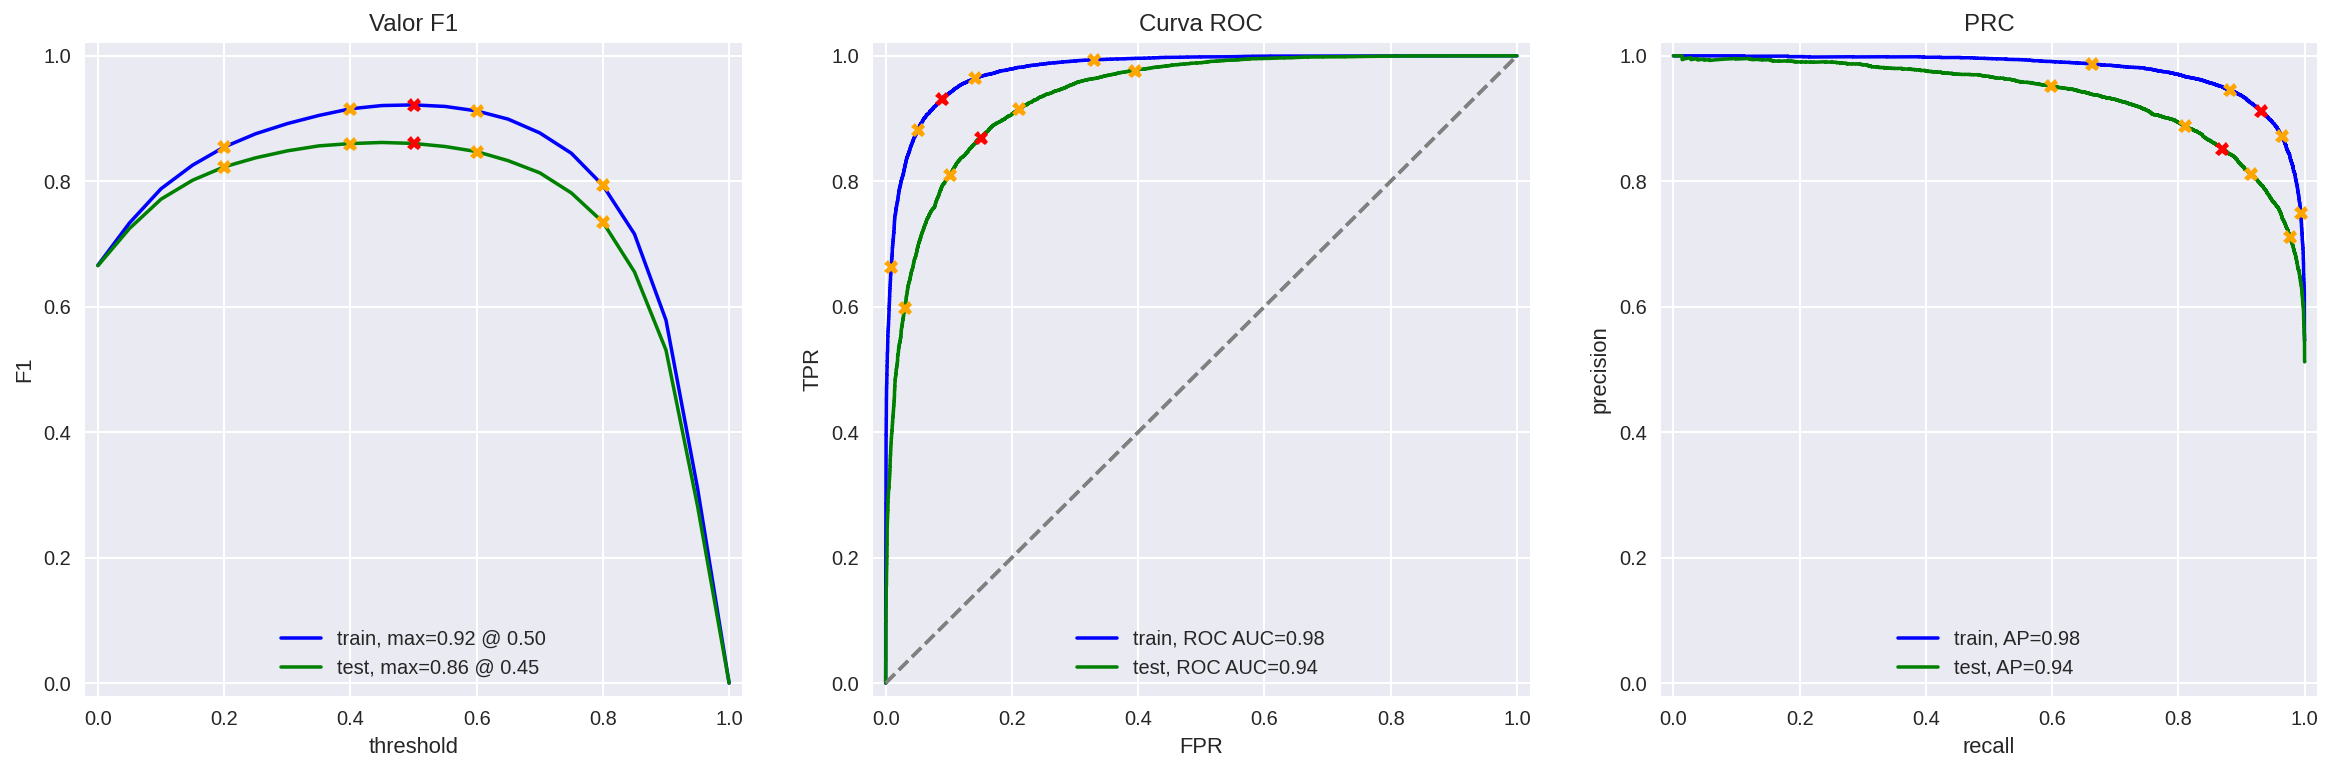

In [45]:
evaluate_model(lgbm_classifier, X_train_tfidf, y_train, X_test_tfidf, y_test)

###  Model 9 - BERT

In [46]:
#import torch
#import transformers

In [47]:
#tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
#config = transformers.BertConfig.from_pretrained('bert-base-uncased')
#model = transformers.BertModel.from_pretrained('bert-base-uncased')

In [48]:
#def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    #ids_list = []
    #attention_mask_list = []
    
     #texto para IDs de tokens preenchidos com suas máscaras de atenção
    
     #<coloque seu código aqui para criar ids_list e attention_mask_list>
    
    #if force_device is not None:
        #device = torch.device(force_device)
    #else:
        #device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
   # model.to(device)
    #if not disable_progress_bar:
        #print(f'Usando o dispositivo {device}.')
    
     #recebendo incorporações em lotes

    #embeddings = []

    #for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
       # ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        

        # <coloque seu código aqui para criar attention_mask_batch
            
      #  with torch.no_grad():            
      #      model.eval()
     #       batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
      #  embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
   # return np.concatenate(embeddings)

In [49]:
# Atenção! A execução do BERT para milhares de textos pode levar muito tempo na CPU, pelo menos várias horas
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [50]:
#print(df_reviews_train['review_norm'].shape)
#print(train_features_9.shape)
#print(train_target.shape)

In [51]:
 #se você tiver as incorporações, é aconselhável salvá-las para tê-las prontas se 
#np.savez_compressed('features_9.npz', train_features_9=train_features_9, test_features_9=test_features_9)

# e carregar...
 #with np.load('features_9.npz') as data:
   # train_features_9 = data['train_features_9']
    #test_features_9 = data['test_features_9']

## My Reviews

In [52]:
# sinta-se à vontade para remover completamente essas resenhas e experimentar seus modelos nas suas próprias resenhas, as abaixo são apenas exemplos

my_reviews = pd.DataFrame([
    'I just did not like it', 
    'it is not my kind of movie',
    'Well, I got bored and fell asleep in the middle of the movie',
    'I was really fascinated by the movie',    
    'The actors looked very old and uninterested, and yet they were paid to be in the movie. What a shameless rip-off',
    'I did not expect the new version to be so good! The writers really cared about the original material',
    'The movie has its pros and cons, but I feel that overall it is a decent movie. I can imagine going to see it again',
    'What a rotten attempt at comedy. Not a single joke lands, everyone acts annoyingly loud, even children will not like it!',
    'Launching on Netflix was a brave move and I really appreciate being able to watch episode after episode of this exciting and intelligent new drama.'
], columns=['review'])
pattern = r"[^a-zA-Z']"

my_reviews['review_norm'] = my_reviews['review'].apply(lambda x: re.sub(pattern, " ", x))

my_reviews

,review,review_norm
0,I just did not like it,I just did not like it
1,it is not my kind of movie,it is not my kind of movie
2,"Well, I got bored and fell asleep in the middl...",Well I got bored and fell asleep in the middl...
3,I was really fascinated by the movie,I was really fascinated by the movie
4,"The actors looked very old and uninterested, a...",The actors looked very old and uninterested a...
5,I did not expect the new version to be so good...,I did not expect the new version to be so good...
6,"The movie has its pros and cons, but I feel th...",The movie has its pros and cons but I feel th...
7,What a rotten attempt at comedy. Not a single ...,What a rotten attempt at comedy Not a single ...
8,Launching on Netflix was a brave move and I re...,Launching on Netflix was a brave move and I re...


In [54]:
my_reviews['pos'] = 0,0,1,0,1,1,0,1,1#feito manualmente

In [55]:
my_reviews

,review,review_norm,pos
0,I just did not like it,I just did not like it,0
1,it is not my kind of movie,it is not my kind of movie,0
2,"Well, I got bored and fell asleep in the middl...",Well I got bored and fell asleep in the middl...,1
3,I was really fascinated by the movie,I was really fascinated by the movie,0
4,"The actors looked very old and uninterested, a...",The actors looked very old and uninterested a...,1
5,I did not expect the new version to be so good...,I did not expect the new version to be so good...,1
6,"The movie has its pros and cons, but I feel th...",The movie has its pros and cons but I feel th...,0
7,What a rotten attempt at comedy. Not a single ...,What a rotten attempt at comedy Not a single ...,1
8,Launching on Netflix was a brave move and I re...,Launching on Netflix was a brave move and I re...,1


In [78]:
X=my_reviews['review_norm']
y=my_reviews['pos']
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y, test_size=0.2, random_state=42)

In [74]:
tfidf_vectorizer1 = TfidfVectorizer()
X_train_tfidf2 = tfidf_vectorizer1.fit_transform(X_train2)
X_test_tfidf2 = tfidf_vectorizer1.transform(X_test2)

In [75]:
y_pred = dummy_classifier.predict(X_test_tfidf2)

# Calculate the accuracy of the DummyClassifier
accuracy = accuracy_score(y_test2, y_pred)
print(f"Accuracy of DummyClassifier: {accuracy}")


Accuracy of DummyClassifier: 0.5


### Model 3

In [84]:
model_31= RandomForestClassifier(n_estimators=100, random_state=42)
model_31.fit(X_train_tfidf2, y_train2)

RandomForestClassifier(random_state=42)

In [85]:
y_val_pred3 = model_31.predict(X_test_tfidf2)
accuracy3 = accuracy_score(y_test2, y_val_pred3)
print(f'Acurácia: {accuracy3:.2f}')

Acurácia: 0.50


In [86]:
f1 = f1_score(y_test2, y_val_pred3)
print("Valor F1:", f1)

Valor F1: 0.0


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         1.0   0.5
ROC AUC     1.0   0.0


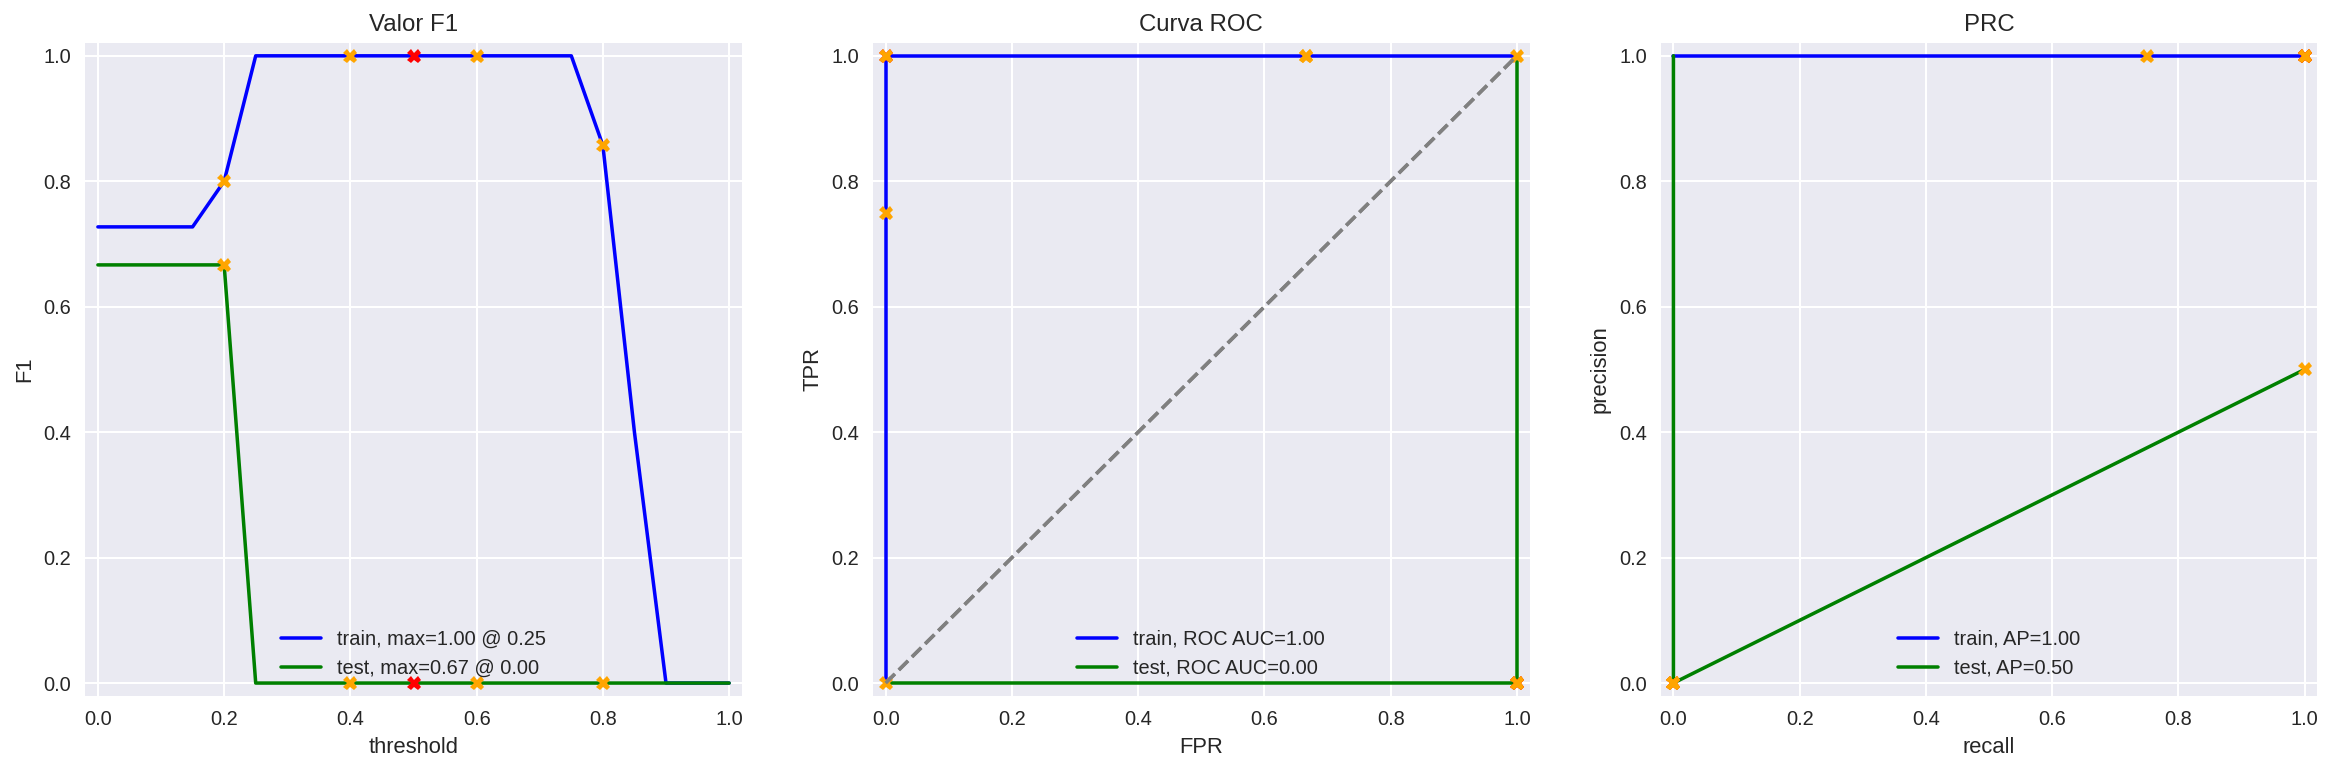

In [87]:
evaluate_model(model_31, X_train_tfidf2, y_train2, X_test_tfidf2, y_test2)

In [88]:
#texts = my_reviews['review_norm']

#my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 4

In [101]:
 
model_41=lgbm_classifier.fit(X_train_tfidf2, y_train2)#usei o modelo anterior

In [102]:
y_pred4 = model_41.predict(X_test_tfidf2)


accuracy4 = accuracy_score(y_test2, y_pred4)
print(f"Acurácia do modelo: {accuracy4}")

Acurácia do modelo: 0.5


In [103]:
f1 = f1_score(y_test2, y_pred4)
print("Valor F1:", f1)

Valor F1: 0.6666666666666666


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.57   0.5
ROC AUC    0.50   0.5


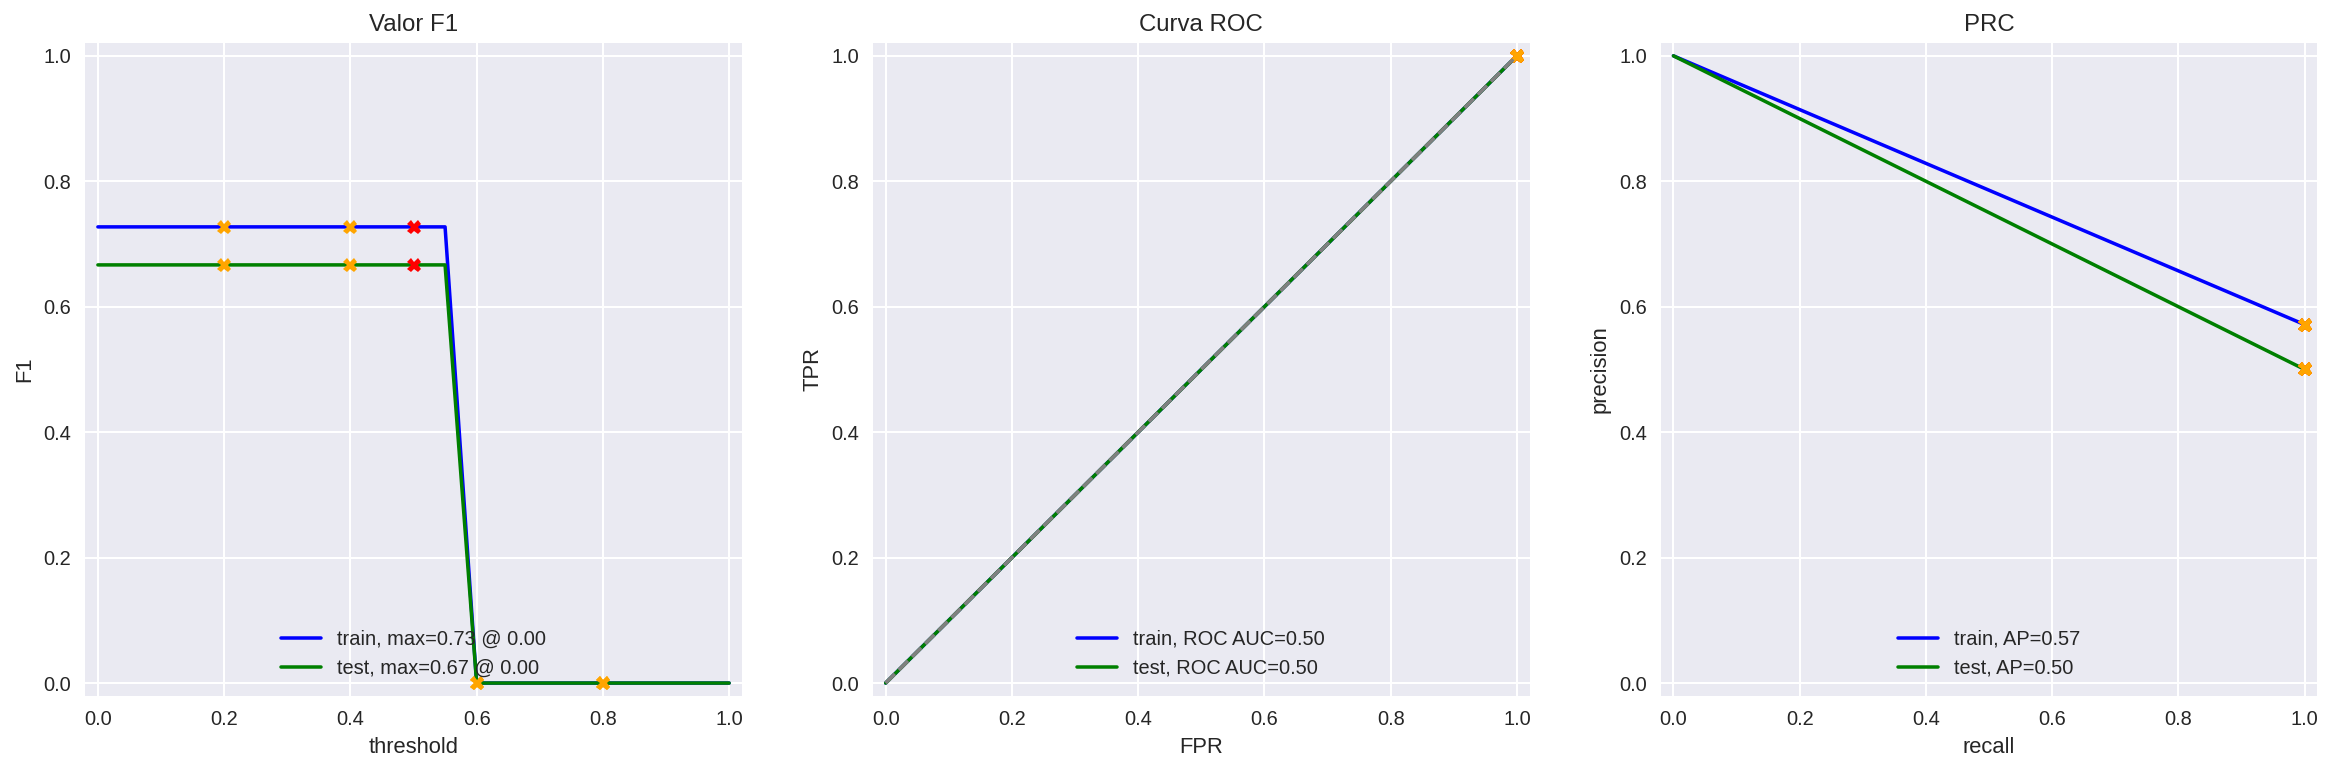

In [104]:
evaluate_model(model_41, X_train_tfidf2, y_train2, X_test_tfidf2, y_test2)

In [105]:
#texts = my_reviews['review_norm']

#tfidf_vectorizer_4 = tfidf_vectorizer_3
#my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

### Model 9

In [106]:
model_51= xgb.XGBClassifier()
model_51.fit(X_train_tfidf2, y_train2)
y_pred5 = model_51.predict(X_test_tfidf2)
accuracy5 = accuracy_score(y_test2, y_pred5)
print(f"Acurácia do modelo: {accuracy5}")

/opt/conda/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[16:06:21] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Acurácia do modelo: 0.5


In [107]:
f1 = f1_score(y_test2, y_pred5)
print("Valor F1:", f1)

Valor F1: 0.6666666666666666


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS        0.57   0.5
ROC AUC    0.50   0.5


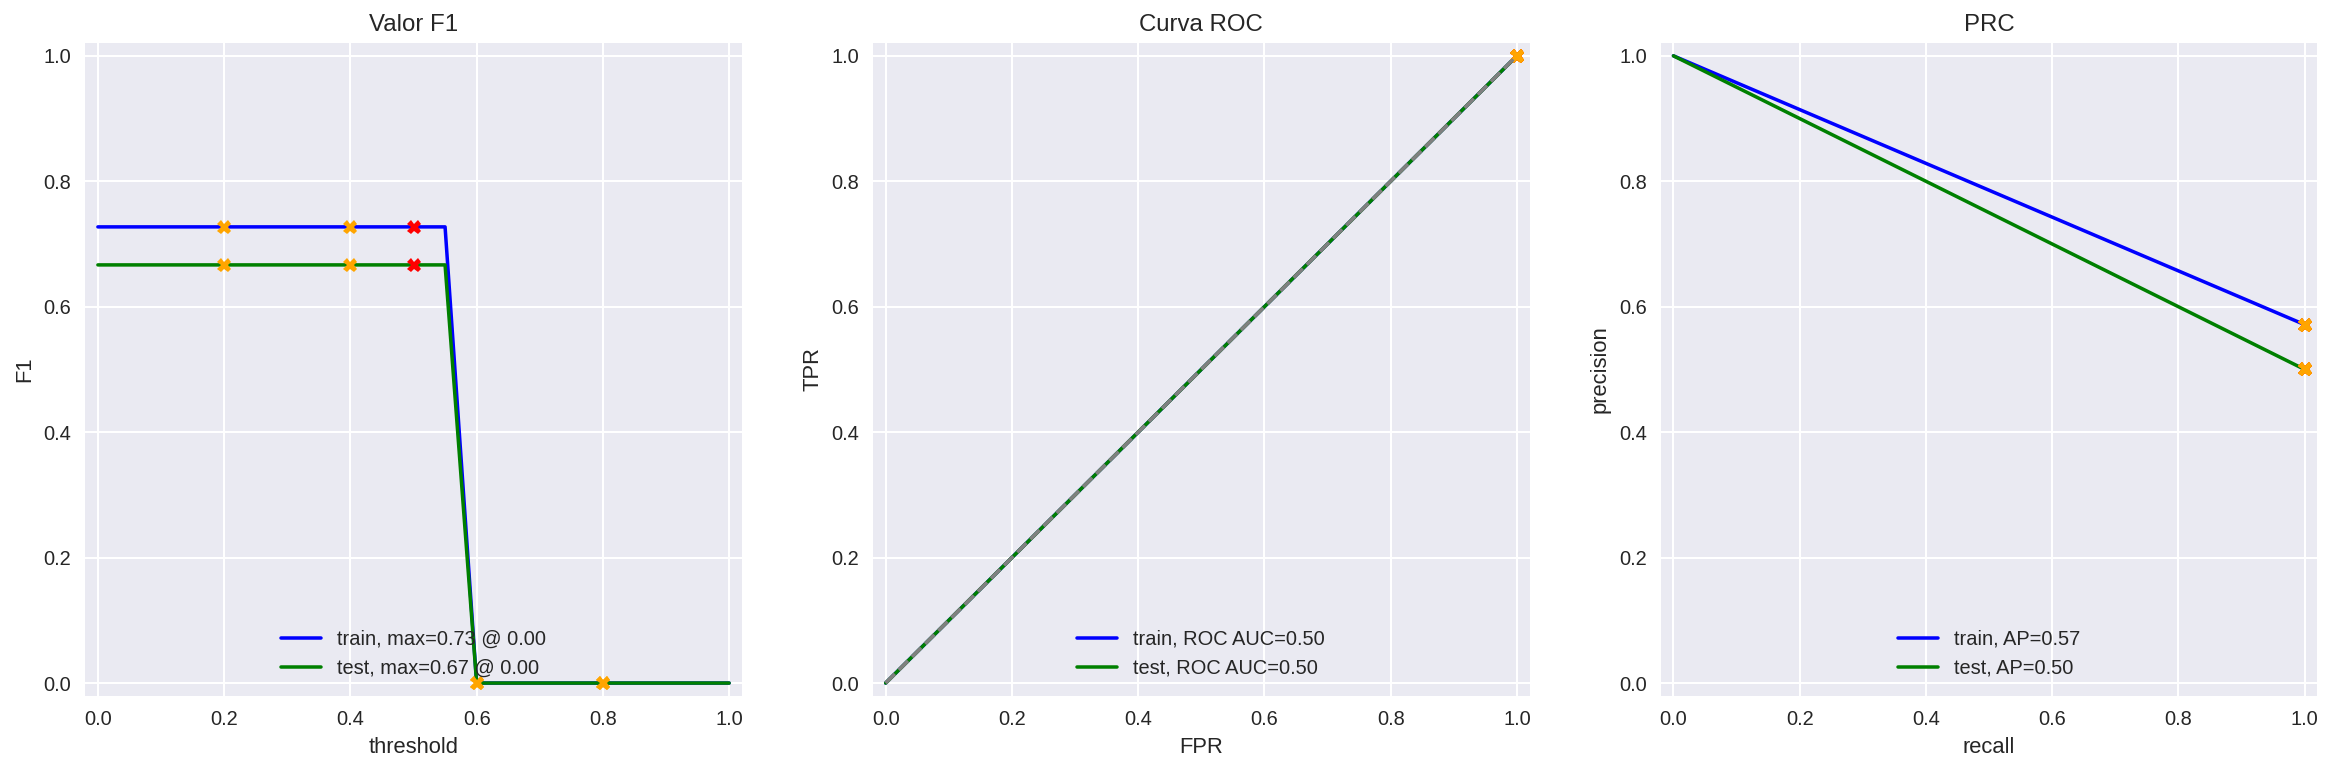

In [108]:
evaluate_model(model_51, X_train_tfidf2, y_train2, X_test_tfidf2, y_test2)

In [109]:
#texts = my_reviews['review_norm']

#my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True)

#my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

#for i, review in enumerate(texts.str.slice(0, 100)):
    #print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

**Other Model**

In [110]:
modelox = CatBoostClassifier(iterations=1000, depth=6, learning_rate=0.1, loss_function='Logloss')
modelox.fit(X_train_tfidf2, y_train2)
y_predx1 = modelox.predict(X_test_tfidf2)
accuracyx = accuracy_score(y_test2, y_predx1)
print(f"Acurácia do modelo: {accuracyx}")

0:	learn: 0.6305723	total: 645us	remaining: 645ms
1:	learn: 0.5755072	total: 1.32ms	remaining: 658ms
2:	learn: 0.5328858	total: 2.06ms	remaining: 685ms
3:	learn: 0.4946100	total: 2.56ms	remaining: 638ms
4:	learn: 0.4726947	total: 3.12ms	remaining: 621ms
5:	learn: 0.4403470	total: 3.87ms	remaining: 641ms
6:	learn: 0.4018139	total: 4.45ms	remaining: 632ms
7:	learn: 0.3615108	total: 4.91ms	remaining: 609ms
8:	learn: 0.3361983	total: 5.64ms	remaining: 622ms
9:	learn: 0.3234889	total: 6.24ms	remaining: 618ms
10:	learn: 0.3050768	total: 7.11ms	remaining: 639ms
11:	learn: 0.2739598	total: 7.51ms	remaining: 619ms
12:	learn: 0.2573730	total: 8.12ms	remaining: 616ms
13:	learn: 0.2400603	total: 8.6ms	remaining: 606ms
14:	learn: 0.2263948	total: 9.09ms	remaining: 597ms
15:	learn: 0.2112243	total: 9.57ms	remaining: 589ms
16:	learn: 0.2003235	total: 10.2ms	remaining: 592ms
17:	learn: 0.1899256	total: 11ms	remaining: 602ms
18:	learn: 0.1804775	total: 11.6ms	remaining: 601ms
19:	learn: 0.1719374	total

In [111]:
f1 = f1_score(y_test2, y_predx1)
print("Valor F1:", f1)

Valor F1: 0.0


          train  test
Acurácia    NaN   NaN
F1          NaN   NaN
APS         1.0   0.5
ROC AUC     1.0   0.0


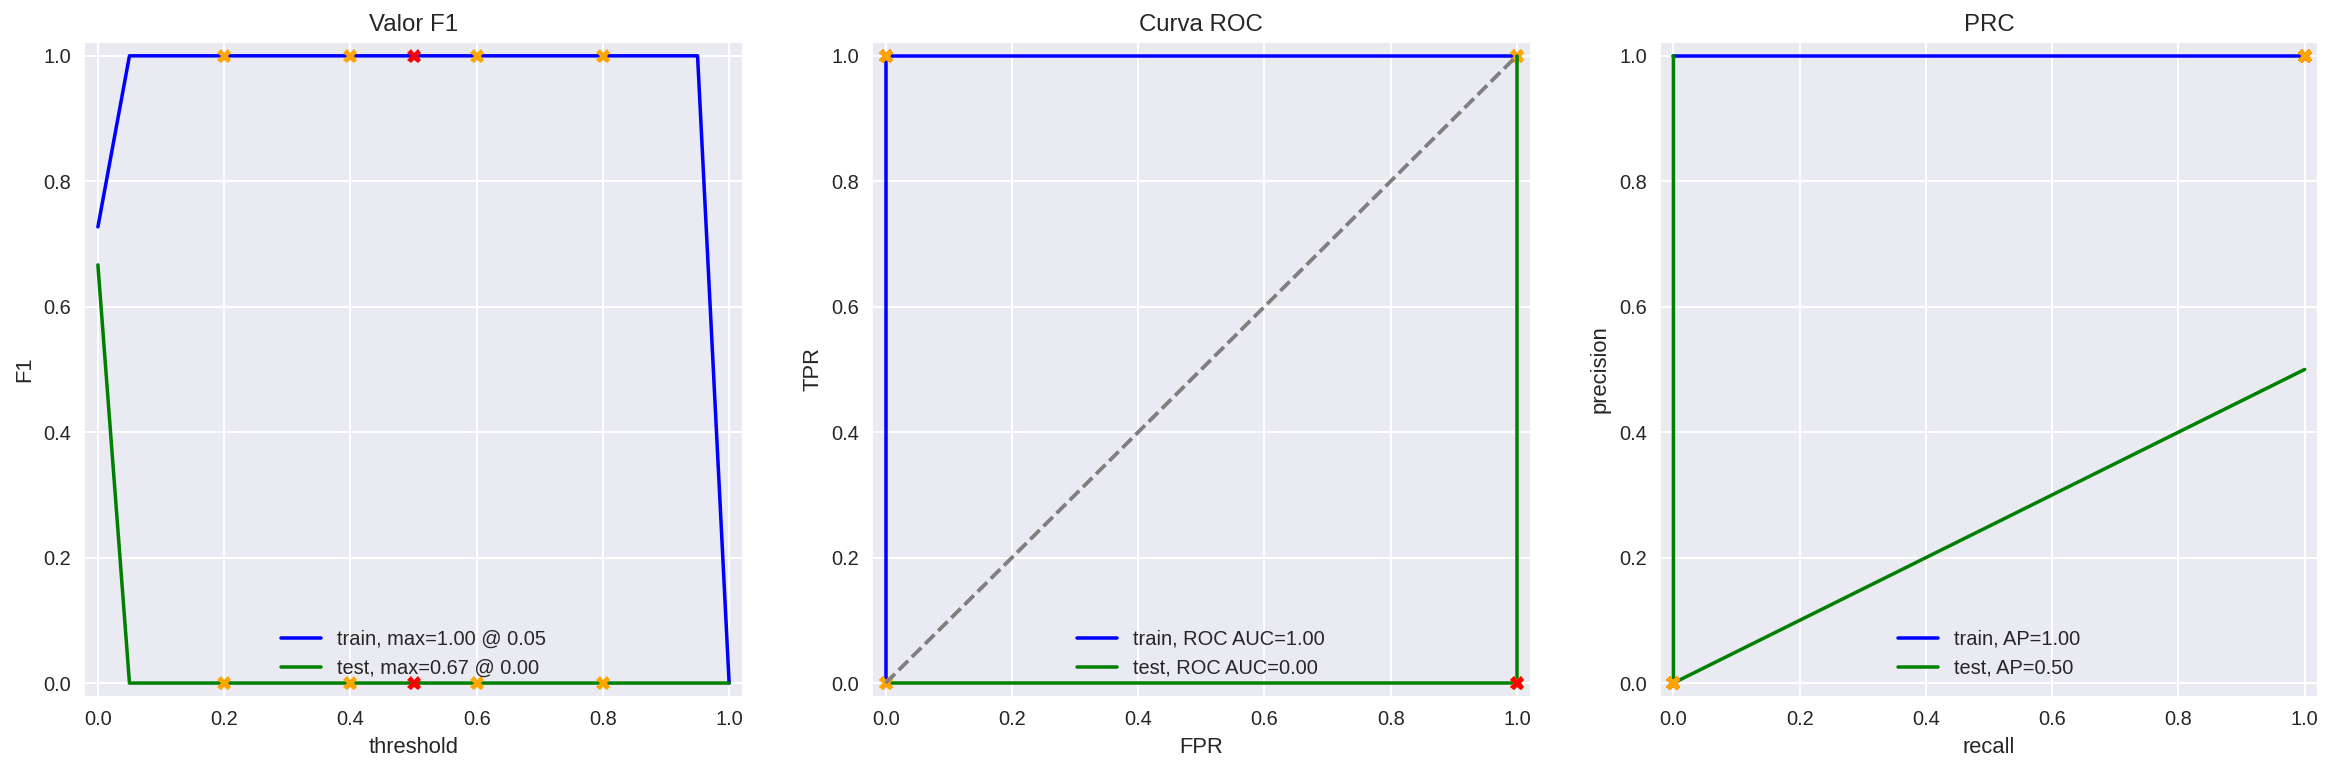

In [112]:
evaluate_model(modelox, X_train_tfidf2, y_train2, X_test_tfidf2, y_test2)

## Conclusions

* Linear regression and LGBM were the best models, the 0 - Constant model performed like a random model.
* Linear regression performed slightly better with the first type of text processing, normalization. With an accuracy of 88% and an f1 value of 0.88. The only difference was the APS value in the test set, from 0.95 with the first model to 0.94 with the second model using other text processing, which obtained a lower f1 value, also resulting in 0.87.
* In my reviews, all the models I tested performed as well as a random model, as I believe the dataframe was too small to work with and I didn't have enough examples, so it resulted in something like 50% accuracy for all the models.